## Task 2

This task focused on training the pre-processed dataset under an MLP classifier without feature selection and evaluate its performance. At a glance, it can be seen that accuracy significantly improves. This gave an indication that the improvement was due to either (i) the MLP classifier or (ii) using all features. This will be evaluated below.

In [1]:
from ipynb.fs.full.functions import (
    load_model, save_model, load_dataset,
    calculate_variance_threshold, pearson_correlation,
    mlp_classifier, find_best_configuration_mlp, svc_classifier, dataset_undersampling, dataset_oversampling,
    plot_feature_split_of_values, plot_class_split_of_values, plot_predicted_vs_actual, plot_confusion_matrix, plot_det_curve, plot_roc_curve, plot_precision_recall_curve, plot_hyperparam_scores_mlp,
    fetch_classification_report, fetch_multiple_classification_report,
    fetch_accuracy_score, fetch_log_loss
)
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

-----
## Fetching Dataset

The saved dataset from Task 1 before feature selection is fetched for training

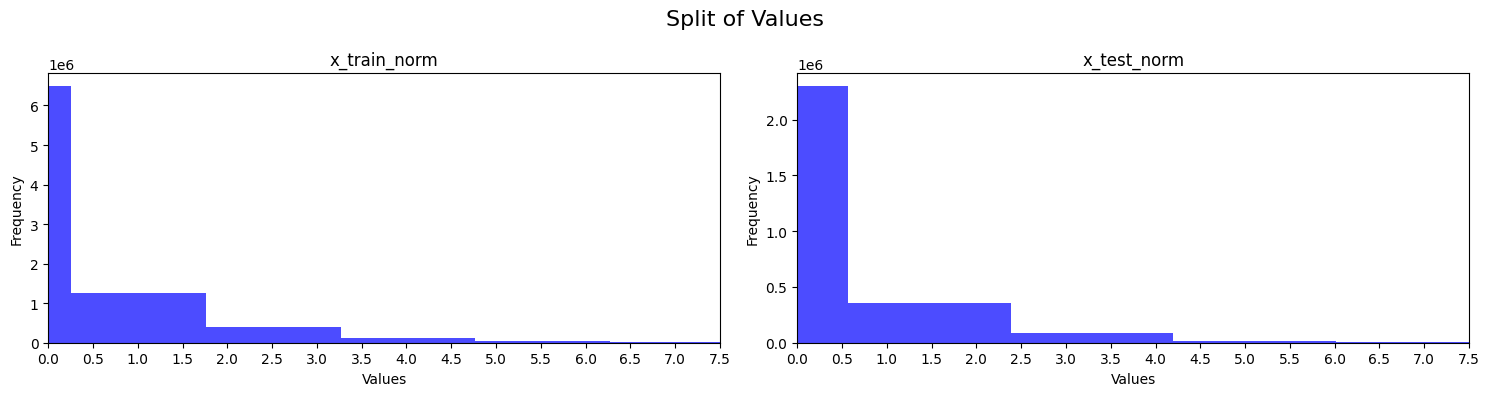

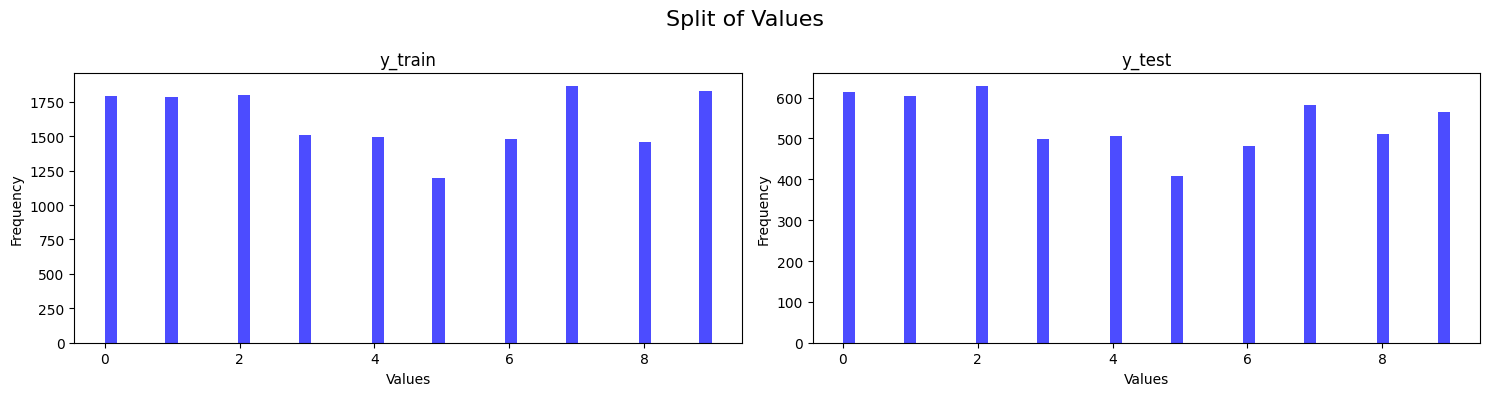

In [2]:
x_train_norm = load_dataset("./datasets/saved_datasets/task1/x_train")
x_test_norm = load_dataset("./datasets/saved_datasets/task1/x_test")
y_train = load_dataset("./datasets/saved_datasets/task1/y_train")
y_test = load_dataset("./datasets/saved_datasets/task1/y_test")

plot_feature_split_of_values([x_train_norm, x_test_norm], ["x_train_norm", "x_test_norm"], 7.5)
plot_class_split_of_values([y_train, y_test], ["y_train", "y_test"])

-----------------------------------------------------------------
## Hyperparameter Optimisation
The hyperparameters were optimised to try to improve the model performance. The hypotheses to test were testing different (i) neural network architectures' impact on the model performance, (ii) activation functions to see how the neurons are activated with biases, (iii) solvers to see how it influences the generalisation of the model, and (iv) alphas to see how regularisation impacts overfitting and generalisation of the model.

1. `hidden layers = (50, 50, 50)`

2. `activation = tanh`

3. `solver = adam`

3. `alpha = 0.0001`

The best performance achieved with this configuration was -> Train accuracy - `1.0`, Test accuracy - `0.924`

<b>Note - Running the code below will take approximately 2 hours to finish execution</b>

{'hidden_layer': (50, 50, 50), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001}
Training accuracy - 1.0
Testing accuracy - 0.9241975308641976


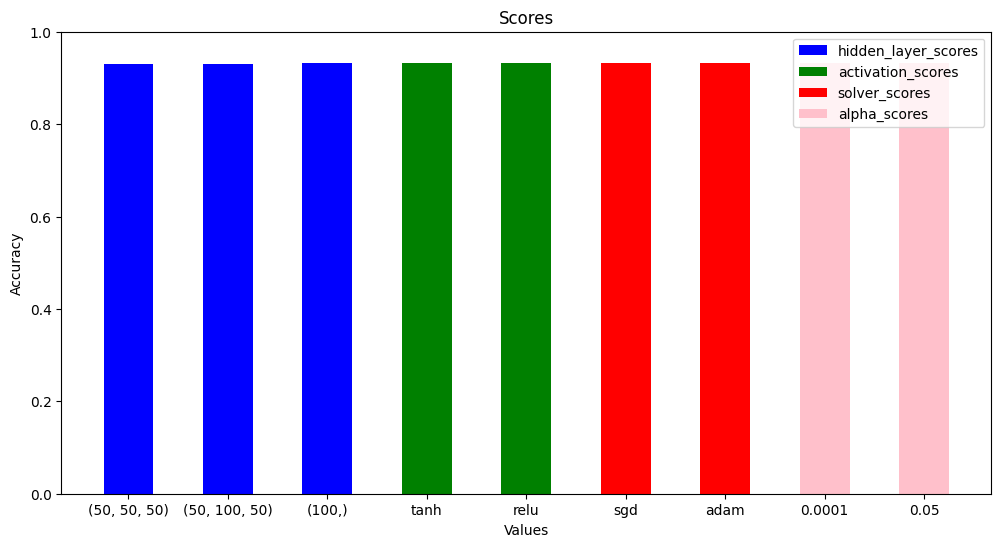

In [34]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
parameters = {
    "hidden_layers": [(50,50,50), (50,100,50), (100,)],
    "activations": ['tanh', 'relu'],
    "solvers": ['sgd', 'adam'],
    "alphas": [0.0001, 0.05]
}

best_config = find_best_configuration_mlp(parameters, x_train_norm, x_test_norm, y_train, y_test, "task2")
print(best_config["parameters"])
print(f"Training accuracy - {best_config["training_accuracy"]}")
print(f"Testing accuracy - {best_config["testing_accuracy"]}")

plot_hyperparam_scores_mlp(best_config["scores"])

---
## MLP Classifier Training

The model was trained with an MLP classifier, with the results being validated using Holdout, Cross Validation (5 folds), and Stratified K-fold Cross Validation (10 folds). Stratified K-fold validation was used to ensure that all data was equially split between samples.

The best accuracy received for training and testing before hyperparameter optimisation was `0.999` and `0.933`. This base model served as the starting benchmark for evaluation.

In [10]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
mlp_training_results = mlp_classifier(x_train_norm, x_test_norm, y_train, y_test, "task2", False)
save_model(mlp_training_results, "models/task2/mlp_results")

------ Holdout Validation ------
Training Accuracy: 0.9998765432098765
Testing Accuracy: 0.9268518518518518
------ Cross Validation ------
Mean Accuracy: 0.9332098765432099
------ Stratified K fold Validation ------
Mean Accuracy: 0.9346296296296297
Std Deviation: 0.004712832591759614
models/task2/mlp_results has the new model!


In [11]:
mlp_training_results = load_model("./models/task2/mlp_results")

-----------------------------------------------------------------
## Evaluation

The classification report was fetched to see the precision and recall for each class and how the model performed in identifying the classes (i.e. True Positives).

It can be seen that the performance overall was significantly better than task 1 with with average precision and recall being `0.92` respectively.

But, it can also be observed that classes `3.0` and `6.0` had the lowest precision and recall values.

In [12]:
fetch_classification_report(mlp_training_results, x_test_norm, y_test)

----- Classification Report -----
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       613
         1.0       0.97      0.97      0.97       605
         2.0       0.92      0.92      0.92       628
         3.0       0.85      0.85      0.85       499
         4.0       0.95      0.95      0.95       507
         5.0       0.89      0.91      0.90       409
         6.0       0.85      0.87      0.86       481
         7.0       0.97      0.97      0.97       583
         8.0       0.91      0.88      0.89       511
         9.0       0.99      0.98      0.98       564

    accuracy                           0.93      5400
   macro avg       0.92      0.92      0.92      5400
weighted avg       0.93      0.93      0.93      5400



#### Confusion Matrix
Whilst the classification report is good at showing (i) the correctness of true positive classifications by the model and (ii) whether all the true positive instances were identified, a deep-dive needed to be done to identify where the model was performing poorly and this was possible through the confusion matrix.

The confusion matrix shed light on 4 metrics - `True Positive`, `True Negative`, `False Positive`, and `False Negative` for each class.

This was needed specifically to evaluate where classes `3.0` and `6.0` were faulting.

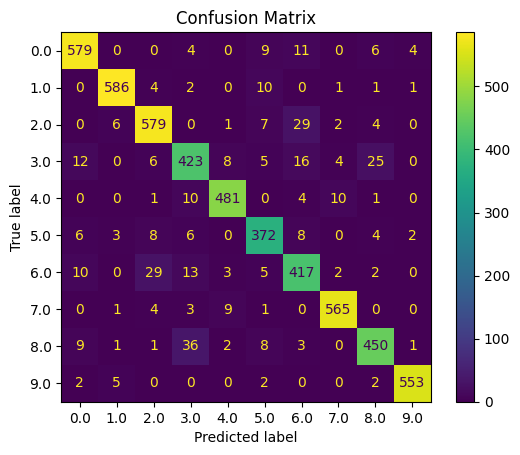

In [13]:
plot_confusion_matrix(mlp_training_results, x_test_norm, y_test, False)

From the confusion matrix and split of metrics, it can be observed that the `Class 3.0` has the highest <b>False Positive</b> value (84) meaning it is misclassyfing the wrong values as true higher than any other class. 

`Class 6.0` has the highest <b>False Negative</b> value (84) means it is misclassifying the most actually true values as false.

#### Precision Recall, ROC, and DET Curve

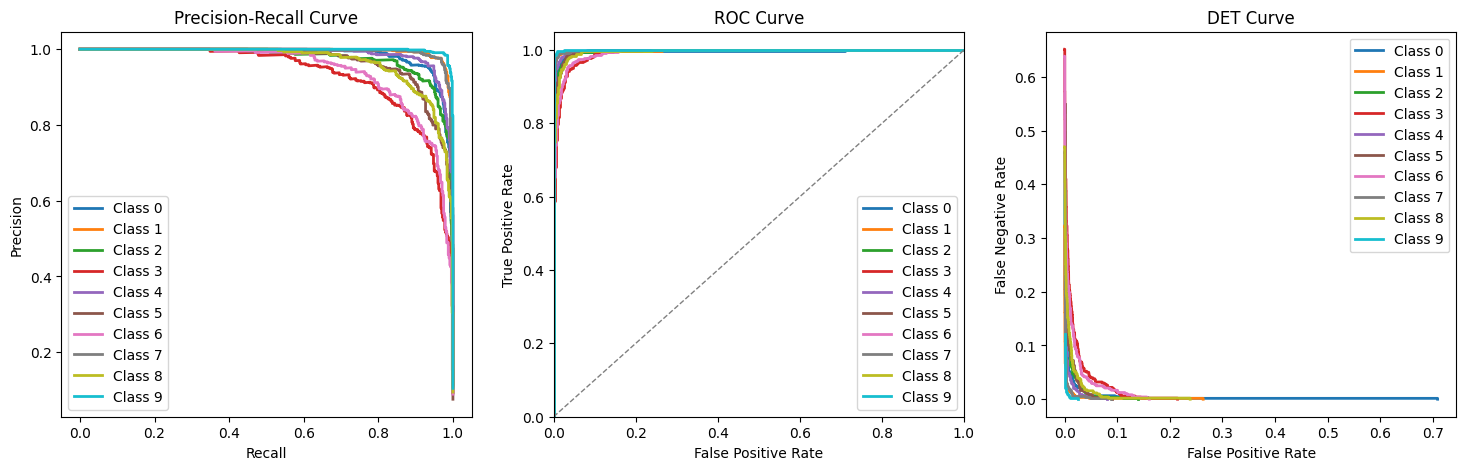

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
y_pred_prob = mlp_training_results.predict_proba(x_test_norm)
plot_precision_recall_curve(y_test, y_pred_prob, axes[0])
plot_roc_curve(y_test, y_pred_prob, axes[1])
plot_det_curve(y_test, y_pred_prob, axes[2])

#### Predicted vs Actual Values

An excerpt from both the predictions and actuals dataset was taken to visualise the difference between the two and in the cases where there was a mismatch, how severe it was. 

<b>Note - In this case, only 500 samples were taken as taking all made the visual unclear</b>

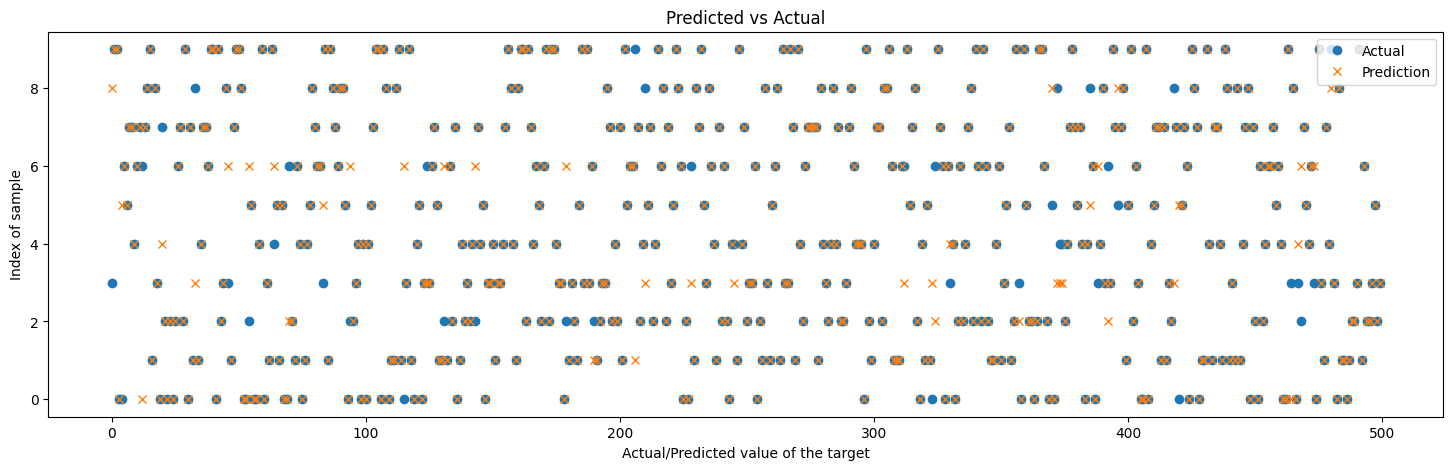

In [15]:
fig, axes = plt.subplots(figsize=(18, 5))
y_pred = mlp_training_results.predict(x_test_norm)
plot_predicted_vs_actual(y_test, y_pred, "Predicted vs Actual", axes, 500)

In [16]:
fetch_accuracy_score(y_test, y_pred)
fetch_log_loss(y_test, y_pred_prob)

Accuracy: 0.9268518518518518
Log Loss: 0.37976440071143813


-----
## Improving Performance

`Class 3.0` and `Class 6.0` have low precision/recall comparatively to the other classes and there were a few hypothesis for the reason:

1. Imbalanced Dataset - To alleviate the imbalance in the number of occurences for each class, <b>undersampling</b> and <b>oversampling</b> was tried.

2. Not being trained under the right number of features

#### Undersampling

In [18]:
# Trained undersampling -> Not taken over original dataset because does not improve accuracy
x_balanced, y_balanced = dataset_undersampling(x_train_norm, y_train)
mlp_undersampling = mlp_classifier(x_balanced, x_test_norm, y_balanced, y_test, "task2", False)
save_model(mlp_undersampling, "models/task2/mlp_results_undersampled")

------ Holdout Validation ------
Training Accuracy: 0.9956485355648536
Testing Accuracy: 0.9242592592592592
------ Cross Validation ------
Mean Accuracy: 0.9241004184100419
------ Stratified K fold Validation ------
Mean Accuracy: 0.9278661087866109
Std Deviation: 0.006806593943987523
models/task2/mlp_results_undersampled has the new model!


In [19]:
x_balanced, y_balanced = dataset_undersampling(x_train_norm, y_train)
mlp_undersampling = load_model("./models/task2/mlp_results_undersampled")

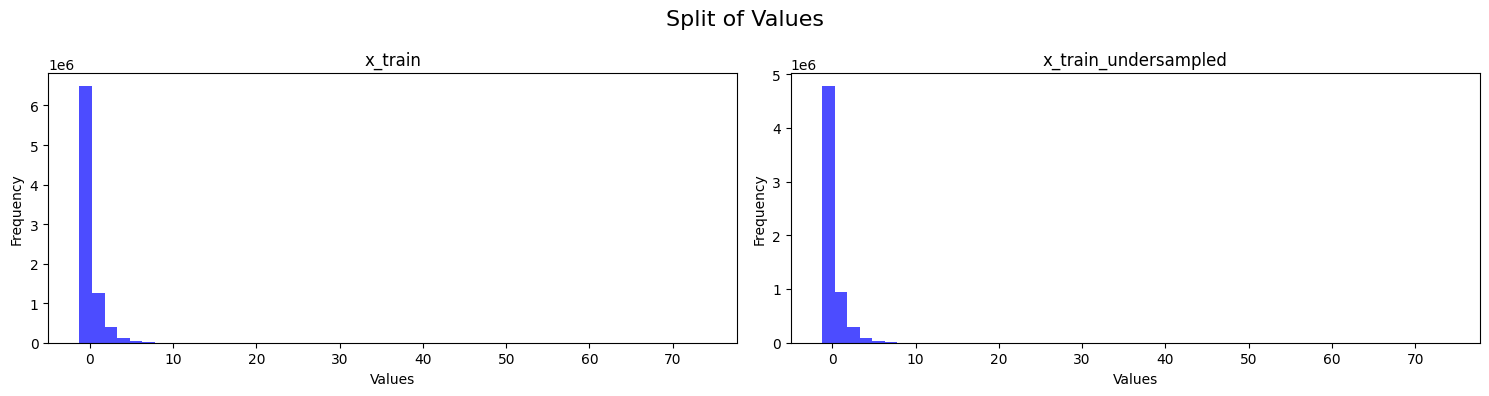

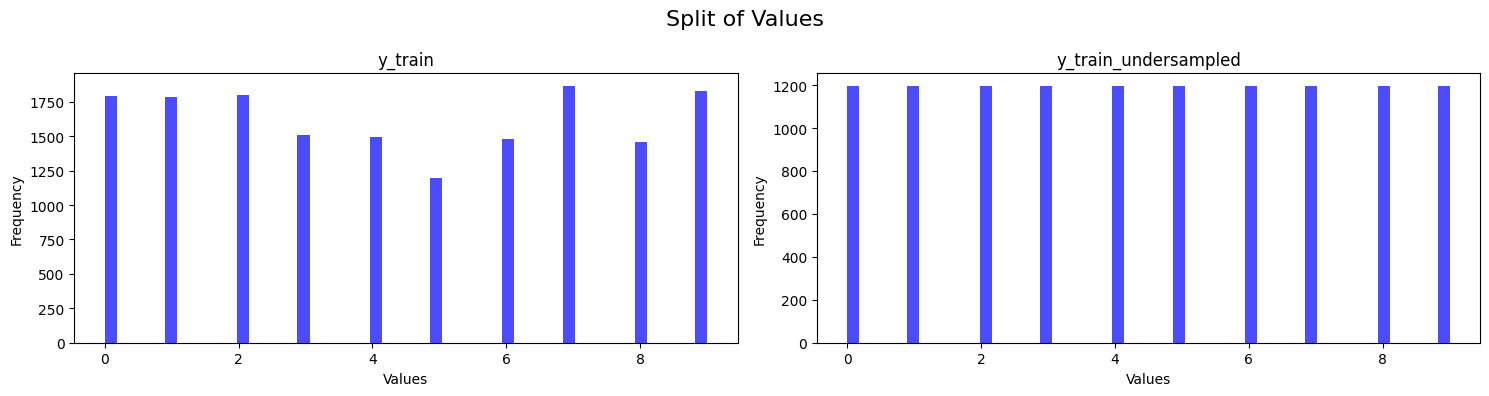

In [20]:
plot_class_split_of_values([x_train_norm, x_balanced], ["x_train", "x_train_undersampled"])
plot_class_split_of_values([y_train, y_balanced], ["y_train", "y_train_undersampled"])

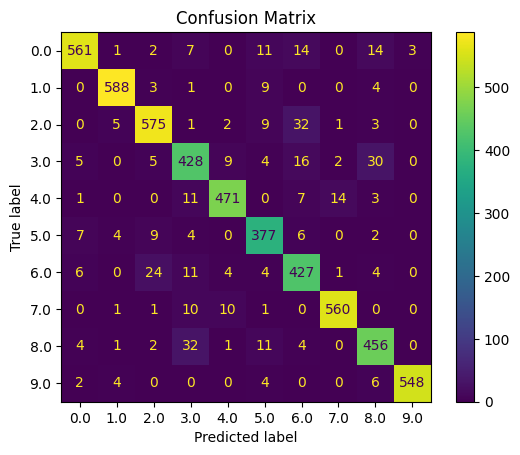

In [21]:
plot_confusion_matrix(mlp_undersampling, x_test_norm, y_test, False)

#### Oversampling

In [22]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
x_balanced_over, y_balanced_over = dataset_oversampling(x_train_norm, y_train)
mlp_oversampling = mlp_classifier(x_balanced_over, x_test_norm, y_balanced_over, y_test, "task2", False)
save_model(mlp_oversampling, "models/task2/mlp_results_oversampled")

------ Holdout Validation ------
Training Accuracy: 0.9949543746645196
Testing Accuracy: 0.9248148148148149
------ Cross Validation ------
Mean Accuracy: 0.9664519592055824
------ Stratified K fold Validation ------
Mean Accuracy: 0.9740740740740741
Std Deviation: 0.004439631665432594
models/task2/mlp_results_oversampled has the new model!


In [23]:
x_balanced_over, y_balanced_over = dataset_oversampling(x_train_norm, y_train)
mlp_oversampling = load_model("./models/task2/mlp_results_oversampled")

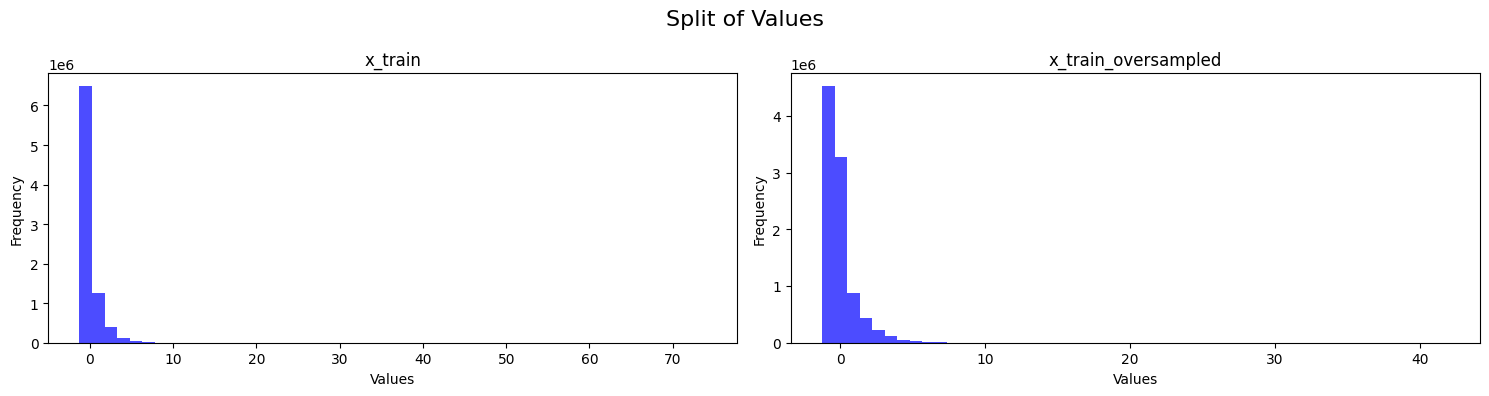

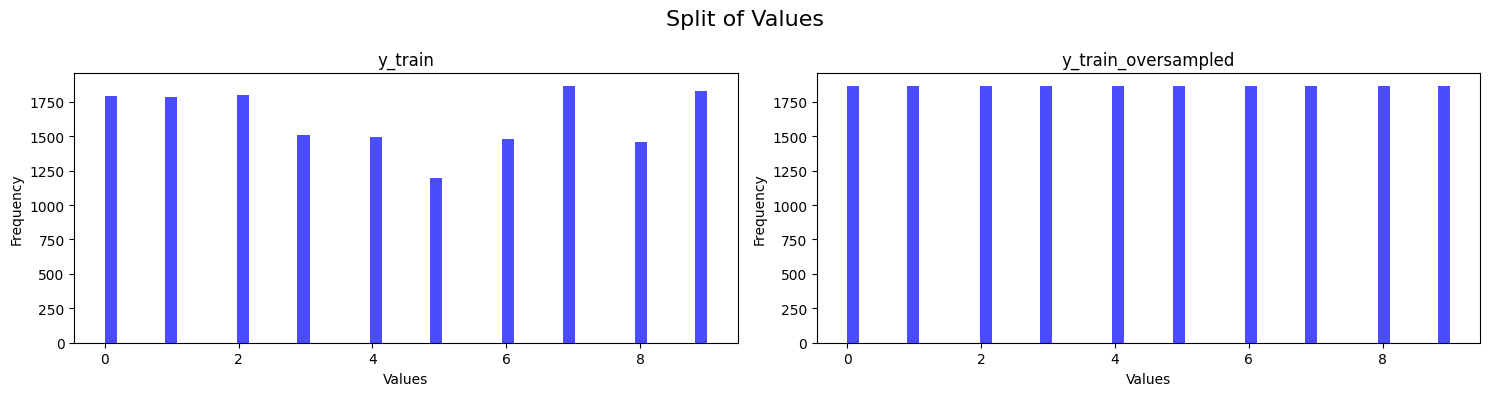

In [24]:
plot_class_split_of_values([x_train_norm, x_balanced_over], ["x_train", "x_train_oversampled"])
plot_class_split_of_values([y_train, y_balanced_over], ["y_train", "y_train_oversampled"])

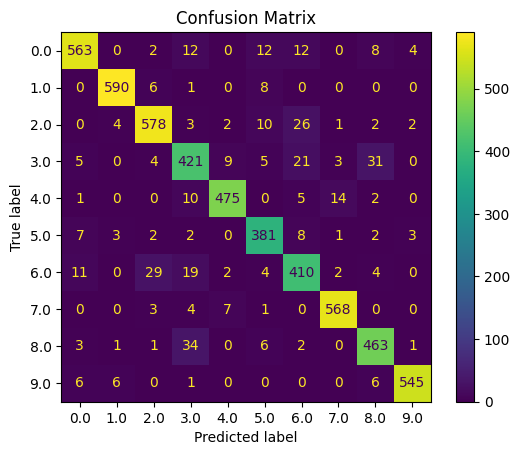

In [25]:
plot_confusion_matrix(mlp_oversampling, x_test_norm, y_test, False)

#### Model Comparison

As seen in the classification report, the original dataset without undersampling and oversampling performed equivalent in predicting classes 3.0 and 6.0 hence, the class imbalance was not the reason for the poor performance of these specific classes

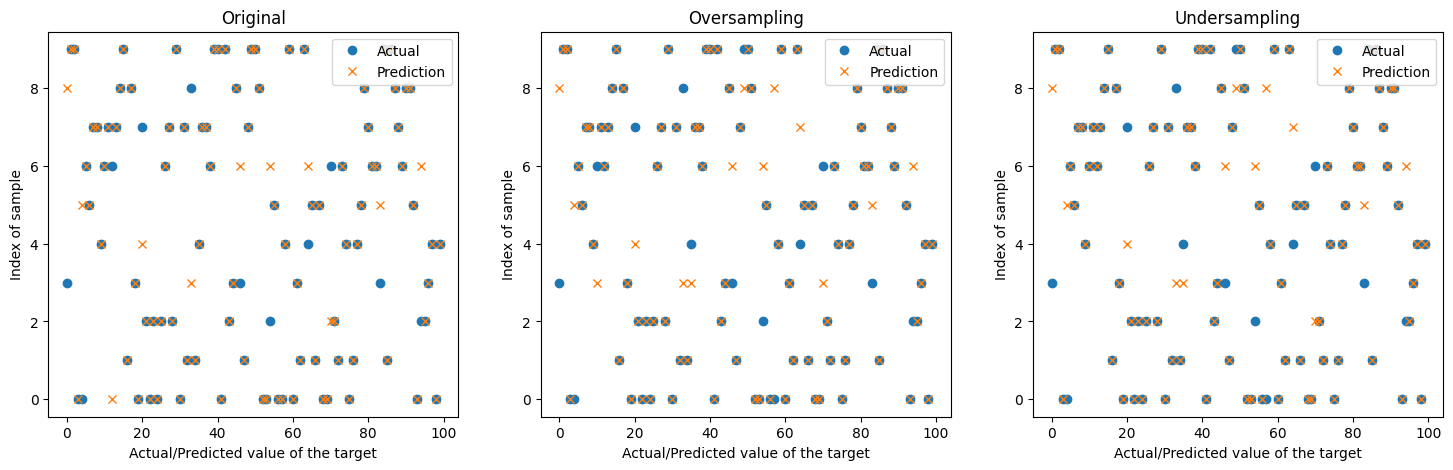

In [26]:
y_pred_oversampling = mlp_oversampling.predict(x_test_norm)
y_pred_undersampling = mlp_undersampling.predict(x_test_norm)
y_pred = mlp_training_results.predict(x_test_norm)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_predicted_vs_actual(y_test, y_pred, "Original", axes[0], 100)
plot_predicted_vs_actual(y_test, y_pred_oversampling, "Oversampling", axes[1], 100)
plot_predicted_vs_actual(y_test, y_pred_undersampling, "Undersampling", axes[2], 100)

In [27]:
# Classification Reports Grouped
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
fetch_multiple_classification_report([mlp_training_results, mlp_undersampling, mlp_oversampling], ["Original Dataset", "Undersampling", "Oversampling"], x_test_norm, y_test)

----- Original Dataset -----
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94       613
         1.0       0.97      0.97      0.97       605
         2.0       0.92      0.92      0.92       628
         3.0       0.85      0.85      0.85       499
         4.0       0.95      0.95      0.95       507
         5.0       0.89      0.91      0.90       409
         6.0       0.85      0.87      0.86       481
         7.0       0.97      0.97      0.97       583
         8.0       0.91      0.88      0.89       511
         9.0       0.99      0.98      0.98       564

    accuracy                           0.93      5400
   macro avg       0.92      0.92      0.92      5400
weighted avg       0.93      0.93      0.93      5400

----- Undersampling -----
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       613
         1.0       0.97      0.97      0.97       605
         2.0       0.93

#### Training under the right number of features
It can be seen that changing the model under different number of features does not have much impact on the precision and recall as it starts levelling out after using the 300 top features with Pearson correlation.

In [31]:
x_train_selected, x_test_selected = calculate_variance_threshold(x_train_norm, x_test_norm, False)
feature_correlation = pearson_correlation(x_train_selected, y_train)
selected_features = x_train_selected[:, feature_correlation[:10]]

def precision_recall_for_class(y_true, y_pred, target_class):
    TP = sum((y_true == target_class) & (y_pred == target_class))
    FP = sum((y_true != target_class) & (y_pred == target_class))
    FN = sum((y_true == target_class) & (y_pred != target_class))
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    print(f"{target_class} -> Precision - {precision}, Recall - {recall}")

for idx in range(100, 500, 50):
    print(f"******** Top {idx} features ********")
    mlp_results = mlp_classifier(x_train_norm[:, feature_correlation[:idx]], x_test_norm[:, feature_correlation[:idx]], y_train, y_test, "task2", False)
    y_pred = mlp_results.predict(x_test_norm[:, feature_correlation[:idx]])
    precision_recall_for_class(y_test, y_pred, 3.0)
    precision_recall_for_class(y_test, y_pred, 6.0)

******** Top 100 features ********
------ Holdout Validation ------
Training Accuracy: 1.0
Testing Accuracy: 0.8796296296296297
------ Cross Validation ------
Mean Accuracy: 0.8808024691358025
------ Stratified K fold Validation ------
Mean Accuracy: 0.8845679012345681
Std Deviation: 0.006325278250592324
3.0 -> Precision - 0.7465618860510805, Recall - 0.7615230460921844
6.0 -> Precision - 0.7722772277227723, Recall - 0.8108108108108109
******** Top 150 features ********
------ Holdout Validation ------
Training Accuracy: 0.9995679012345678
Testing Accuracy: 0.8983333333333333
------ Cross Validation ------
Mean Accuracy: 0.9024691358024691
------ Stratified K fold Validation ------
Mean Accuracy: 0.9050617283950617
Std Deviation: 0.007564184534340936
3.0 -> Precision - 0.7648183556405354, Recall - 0.8016032064128257
6.0 -> Precision - 0.7857142857142857, Recall - 0.8461538461538461
******** Top 200 features ********
------ Holdout Validation ------
Training Accuracy: 1.0
Testing Accura

----
As stated at the start of the notebook, the 2 hypothesis to be validated to pinpoint the improvement in overall model performance is whether it was (i) using the MLP Classifier or (ii) Use of all features or both.

>First - The comparison of the SVC with the top 10 selected features against MLP

In [29]:
x_train_selected, x_test_selected = calculate_variance_threshold(x_train_norm, x_test_norm, False)
feature_correlation = pearson_correlation(x_train_selected, y_train)
top_features_indices = feature_correlation[:10]

In [33]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
print("------ MLP ------")
mlp_10_features = mlp_classifier(x_train_selected[:, top_features_indices], x_test_selected[:, top_features_indices], y_train, y_test, "task2", False)
print("------ SVC ------")
svc_10_features = svc_classifier(x_train_selected[:, top_features_indices], x_test_selected[:, top_features_indices], y_train, y_test, "task1", False)
save_model(mlp_10_features, "models/task2/mlp_results_10_features")
save_model(svc_10_features, "models/task2/svc_results_10_features")

------ MLP ------
------ Holdout Validation ------
Training Accuracy: 0.6181481481481481
Testing Accuracy: 0.5857407407407408
------ Cross Validation ------
Mean Accuracy: 0.5881481481481481
------ Stratified K fold Validation ------
Mean Accuracy: 0.5891358024691359
Std Deviation: 0.006869347033700536
----------------------
------ SVC ------
------ Holdout Validation ------
Training Accuracy: 0.6041975308641976
Testing Accuracy: 0.5766666666666667
------ Cross Validation ------
Mean Accuracy: 0.5765432098765432
------ Stratified K fold Validation ------
Mean Accuracy: 0.577716049382716
Std Deviation: 0.009785264934893697
models/task2/mlp_results_10_features has the new model!
models/task2/svc_results_10_features has the new model!


<b>Conclusion - less accuracy with MLP trained model with the top 10 features</b>

>Second - The comparison of SVC and MLP with all features

In [ ]:
svc_classifier(x_train_norm, x_test_norm, y_train, y_test)

------ Holdout Validation ------
Training Accuracy: 0.9761728395061728
Testing Accuracy: 0.9305555555555556
------ Cross Validation ------
Mean Accuracy: 0.9348765432098766
------ K fold Validation ------
Mean Accuracy: 0.9393518518518519
Std Deviation: 0.005512953943186738
------ Stratified K fold Validation ------
Mean Accuracy: 0.9388888888888889
Std Deviation: 0.0045124047892634135


SVC(C=1, probability=True)

In [ ]:
mlp_classifier(x_train_norm, x_test_norm, y_train, y_test)

------ Holdout Validation ------
Training Accuracy: 0.9640123456790124
Testing Accuracy: 0.9248148148148149
------ Cross Validation ------
Mean Accuracy: 0.9309876543209876
------ K fold Validation ------
Mean Accuracy: 0.9270987654320987
Std Deviation: 0.005204622592155881
------ Stratified K fold Validation ------
Mean Accuracy: 0.9253086419753085
Std Deviation: 0.0069344921827079594


MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 100, 50),
              random_state=42, shuffle=False, solver='sgd')

<b style="color: aqua">Conclusion - After evaluating both hypothesis, it can be seen that whilst using MLP actually decreases the accuracy of the model, adding more features significantly improves the performance.</b>